# Session 2 - Practical: Introduction to JAX and coding a PINN from scratch in JAX

## Goal

The goal of this practical is to:
- Learn the basics of JAX, including its core concept of **function transformation**
- Use these basic ideas to train a **physics-informed neural network** (PINN) **from scratch** in JAX, and **compare its performance** to the PyTorch version trained in Session 1.

## Contents

This practical has two parts:
- Part 1: Introduction to **JAX**
- Part 2: Training a **PINN** to solve the 1D harmonic oscillator equation.

Please see the lecture slides from Session 1 and 2 for more explanation on these topics.

## Part 1: Introduction to **JAX**

### Step 1: Code-along with Lecture

This step is a code-along; please follow along with the lecture.

#### What is JAX?

<img src="https://raw.githubusercontent.com/benmoseley/intro-to-jax-workshop/main/what-is-jax.png" width=80%>

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=2'
import jax
import matplotlib.pyplot as plt
import numpy as np

#### Arrays with JAX NumPy

In [2]:
import jax.numpy as jnp

x = jnp.array([[0., 2., 4.]])
print(x, x.shape)
print(x @ x.T)
print(x * x.T)

[[0. 2. 4.]] (1, 3)
[[20.]]
[[ 0.  0.  0.]
 [ 0.  4.  8.]
 [ 0.  8. 16.]]


#### Autodifferentiation with JAX

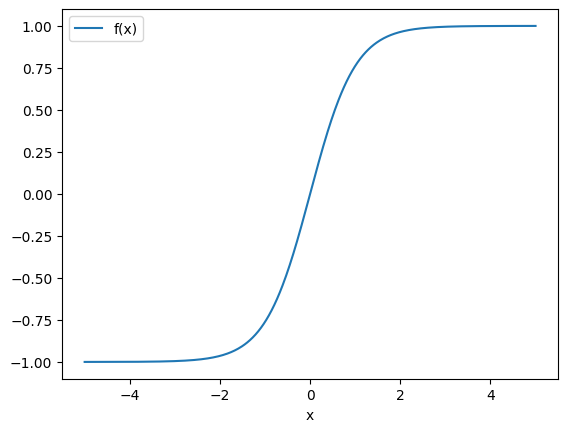

In [3]:
def fn(x):
    return jnp.tanh(x)

x = jnp.linspace(-5,5,500)

plt.plot(x, fn(x), label="f(x)")
plt.legend()
plt.xlabel("x")
plt.show()

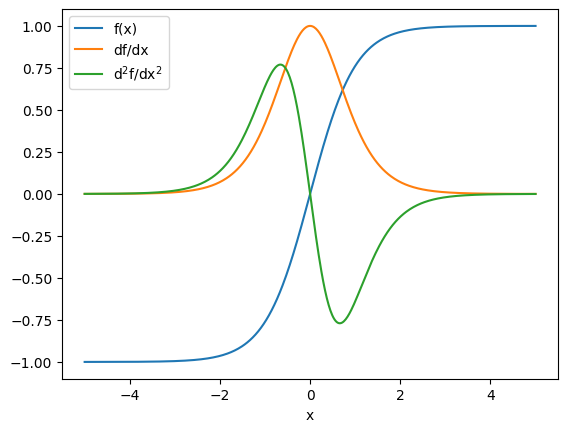

In [4]:
# gradient
dfdx_fn = jax.grad(fn)# assumes f is a scalar-output function
d2fdx2_fn = jax.grad(dfdx_fn)

plt.plot(x, fn(x), label="f(x)")
plt.plot(x, [dfdx_fn(x_) for x_ in x], label="df/dx")
plt.plot(x, [d2fdx2_fn(x_) for x_ in x], label="d$^2$f/dx$^2$")
plt.legend()
plt.xlabel("x")
plt.show()

In [5]:
print(jax.make_jaxpr(fn)(x))# JAX transforms programs using a simple intermediate language call jaxpr

{ lambda ; a:f32[500]. let b:f32[500] = tanh a in (b,) }


In [6]:
# Jacobian
jacobian_fn = jax.jacfwd(fn)
j = jacobian_fn(x)
print(j)
print(j.shape)

[[0.00018167 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00018894 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00019669 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00019669 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00018894 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00018167]]
(500, 500)


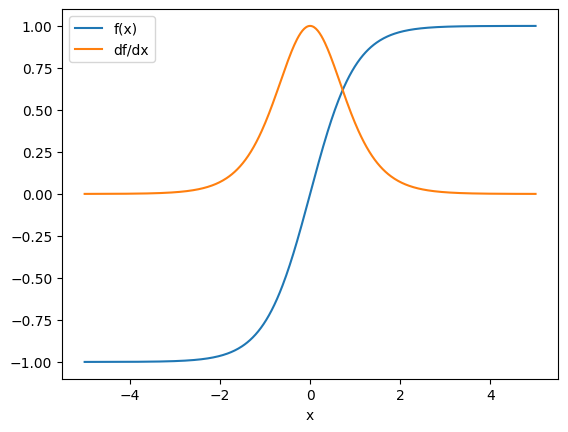

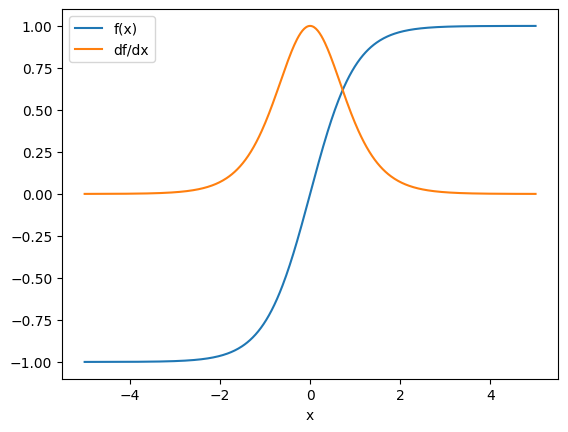

In [7]:
# vector-Jacobian product
f, vjp_fn = jax.vjp(fn, x)
dfdx, = vjp_fn(jnp.ones_like(x))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

# Jacobian-vector product
f, dfdx = jax.jvp(fn, (x,), (jnp.ones_like(x),))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

#### Vectorisation with JAX

In [8]:
def forward_fn(w, b, x):
    x = w @ x + b
    x = jnp.tanh(x)
    return x

key = jax.random.key(seed=0)
key1, key2, key3 = jax.random.split(key, 3)
x = jax.random.normal(key1, (3,))
w = jax.random.normal(key2, (10,3))
b = jax.random.normal(key3, (10,))
y = forward_fn(w, b, x)
print(x.shape)
print(y.shape)

(3,)
(10,)


In [9]:
forward_batch_fn = jax.vmap(forward_fn, in_axes=(None, None, 0))# computes batch using vectorisation

x_batch = jax.random.normal(key, (1000,3))
y_batch = forward_batch_fn(w, b, x_batch)
print(x_batch.shape)
print(y_batch.shape)

(1000, 3)
(1000, 10)


#### Just-in-time compilation with JAX

In [10]:
def fn(x):
    return x + x*x + x*x*x

jit_fn = jax.jit(fn)

x = jax.random.normal(key, (1000,1000))
%timeit fn(x).block_until_ready()
%timeit jit_fn(x).block_until_ready()

5.36 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
484 µs ± 82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Step 2: Your first JAX code: carrying out polynominal regression

The goal of this task is to gain a basic familiarity with JAX's function transforms (`vmap`, `jit`, `grad`).

We will carry out polynominal regression, using the following data:

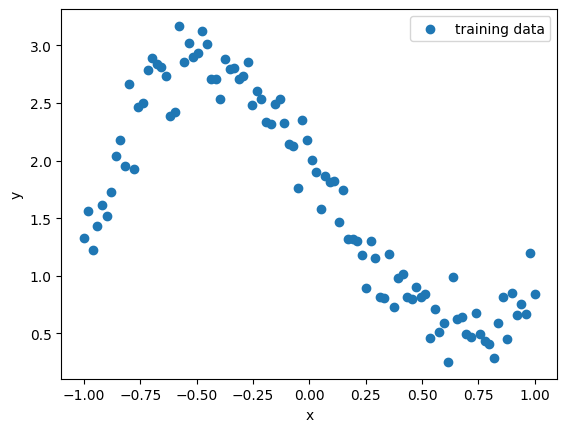

In [11]:
key = jax.random.key(0)
x_batch = jnp.linspace(-1, 1, 100).reshape((100,1))
y_label_batch = 3*x_batch**3 - x_batch**2 - 3*x_batch + 2 + 0.2*jax.random.normal(key, (100,1))

plt.scatter(x_batch, y_label_batch, label="training data")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()

> Task 1: define a `forward(theta, x)` function, which predicts `y` given a single `x` value and some learnable parameters, `theta`.

> Task 2: use `jax.vmap` to transform `forward` to a function which predicts a batch of `y` values given a batch of `x` values. Test that it works using `x_batch` above.

Hint: you can assume that the function is a third order polynominal, and learn its coefficients.

In [12]:
def forward(theta, x):
    "Returns model prediction, for a single example input"
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y

forward_batch = jax.vmap(forward, in_axes=(None, 0))# batched version of forward

theta = jnp.zeros(4, dtype=float)
print(forward_batch(theta, x_batch).shape)

(100, 1)


> Task 3: next, define a `loss(theta, x_batch, y_label_batch)` function which computes the mean-squared error of the model.

> Task 4: use `jax.grad` to transform `loss` into a function which computes the gradient of `loss` with respect to the model parameters, `theta`. Test that it outputs an array the same shape as `theta`.

In [13]:
def loss(theta, x_batch, y_label_batch):
    "Computes mean squared error between model prediction and training data"
    y_batch = forward_batch(theta, x_batch)
    loss = jnp.mean((y_batch-y_label_batch)**2)
    return loss

grad = jax.value_and_grad(loss, argnums=0)# gradient of loss wrt model parameters

print(grad(theta, x_batch, y_label_batch)[1])

[ 0.34816062 -0.9725055   0.79142916 -3.3635862 ]


> Task 5: define an `step(lrate, theta, x_batch, y_label_batch)` function which carries out a single gradient descent step on `theta`, using the `grad` function you created above. It should return the updated `theta`.

> Task 6: use `jax.jit` to compile `step`.

In [14]:
def step(lrate, theta, x_batch, y_label_batch):
    "Performs one gradient descent step on model parameters, given training data"
    lossval, dldt = grad(theta, x_batch, y_label_batch)
    theta = jax.tree_util.tree_map(lambda t,dt: t-lrate*dt, theta, dldt)
    return theta, lossval

jit_step = jax.jit(step)# makes step go brr

> Task 7: finally, write a python `for` loop to train the model over 1000 gradient descent steps, with a learning rate of 0.1. You are free to choose how to initialise `theta`. Plot the results of the model.

> Task 8: compare the speed of training with/without `jit` compilation. How much faster is the compiled code?

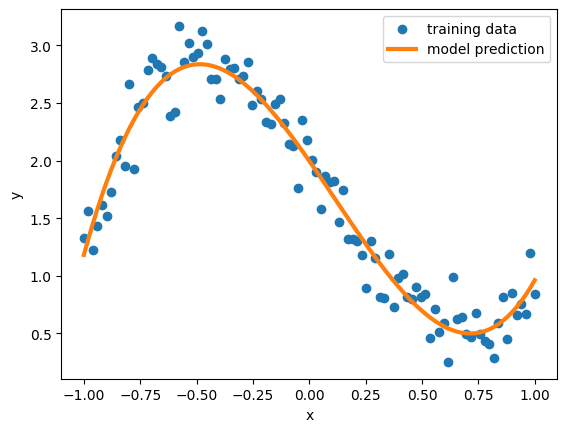

[ 2.7081437 -0.926273  -2.8177862  1.9967881]
34.7 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
13.7 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# initialise theta
theta = jnp.zeros(4, dtype=float)

# run gradient descent
for i in range(1000):
    theta, lossval = jit_step(0.1, theta, x_batch, y_label_batch)

plt.scatter(x_batch, y_label_batch, label="training data")
plt.plot(x_batch, forward_batch(theta, x_batch), color="tab:orange", lw=3, label="model prediction")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()
print(theta)

%timeit jit_step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()
%timeit step(0.1, theta, x_batch, y_label_batch)[1].block_until_ready()

### Extra note: 🔪 JAX: the sharp bits

JAX introduces a number of **restrictions** which are necessary for JAX transformations to work (`vmap`, `grad`, `jit`, etc).

Below are most of the major ones. See [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) for a full list.

#### 🔪 Pure functions

JAX transforms are designed to work on pure functions.

That is, all the input data is passed through the function parameters, and all the results are output through the function results.

Otherwise unexpect results might occur! Note: this makes transforming Python classes tricky (but not [impossible](https://jax.readthedocs.io/en/latest/stateful-computations.html))

In [16]:
x = 10
def f(a):
    return x+a

print(jax.make_jaxpr(f)(1))# when we jit this function, the current value of x is hard-coded into the compiled code!
jit_f = jax.jit(f)
print(jit_f(1))
x = 20
print(jit_f(1))# (!) not what you expect (!)

{ lambda ; a:i32[]. let b:i32[] = add 10 a in (b,) }
11
11


#### 🔪🔪 Static shapes
JAX transforms require all output shapes to be known in **advance**, given the input shapes.

This is probably the biggest restriction. We can't transform functions which output dynamic shapes:

In [17]:
def f(i):
    return jnp.ones(shape=(i,))

print(f(jnp.array(10)))
#print(jax.jit(f)(jnp.array(10)))# raises a TypeError

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


🔪 This means **dynamic programming** and **sparse (matrix) computation** can often be challenging in JAX (although tricks like masking and compressed representations can be used).

#### 🔪 Out-of-place array updates

JAX only allows **out-of-place** array updates.

This is because allowing mutation of variables in-place makes program analysis and transformation difficult.

In [18]:
a = np.array([1,2,3])
a[0] = -1# you are used to doing this

a = jnp.array([1,2,3])
#a[0] = 1# will raise a TypeError
b = a.at[0].set(-1)# this is the JAX equivalent
print(b)

[-1  2  3]


#### 🔪 Random numbers

JAX handles random number generation explicitly ([for good reason](https://jax.readthedocs.io/en/latest/random-numbers.html)).

This means the user must explicitly carry around the state of the random number generator:

In [19]:
key = jax.random.key(0)
print(jax.random.normal(key, (1,)))
print(jax.random.normal(key, (1,)))# generates same number
key, subkey = jax.random.split(key, num=2)# we need to explicitly split the RNG to generate new numbers
print(jax.random.normal(subkey, (1,)))

[1.6226422]
[1.6226422]
[-2.4424558]


## Part 2: Training a **PINN** to solve the 1D harmonic oscillator equation

<div style="text-align: center; margin-top: 20px">
    <img src="images/example_solution.png" width=500px>
</div>
<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/benmoseley/AISE-2024/main/5_introduction_to_PINNs/oscillator.gif" width=500px>
</div>
<div style="text-align: center; font-weight: bold; margin-top: 5px; margin-bottom: 20px">
    Fig 1: Example PINN solution (top) for the 1D harmonic oscillator problem (bottom)
</div>

### Goal

In this part, the goal is to **rewrite the PyTorch PINN code from Session 1 (training a PINN to solve the harmonic oscillator problem) into JAX**.

We want to replicate the exact same hyperparmeters and setup, and test how JAX compares to PyTorch in terms of speed.

We will be using all of the JAX functionality you learnt above; `jax.numpy`, `vmap`, `grad`, and `jit`, to write a performant PINN implementation.

In [20]:
import time
from functools import partial

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import jax
import jax.numpy as jnp
import optax

def exact_solution(d, w0, t):
    "Computes the analytical solution to the under-damped harmonic oscillator."
    assert d < w0
    w = jnp.sqrt(w0**2-d**2)
    phi = jnp.arctan(-d/w)
    A = 1/(2*jnp.cos(phi))
    cos = jnp.cos(phi+w*t)
    exp = jnp.exp(-d*t)
    u = exp*2*A*cos
    return u

def plot_result(i, t_physics_batch, t_boundary, t_test_batch, u_exact_batch, u_test_batch):
    "Plots the PINN's prediction"
    test_error = jnp.mean(jnp.abs(u_test_batch-u_exact_batch)/u_exact_batch.std())
    plt.figure(figsize=(8,3))
    plt.scatter(t_physics_batch[:,0], jnp.zeros_like(t_physics_batch)[:,0], s=20, lw=0, color="tab:blue", alpha=0.6, label="Collocation points")
    plt.scatter(t_boundary, 0, s=20, lw=0, color="tab:red", alpha=0.6, label="Boundary point")
    plt.plot(t_test_batch[:,0], u_exact_batch[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(t_test_batch[:,0], u_test_batch[:,0], label="PINN solution", color="tab:green")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Training step {i+1}    Relative L1 test error: {test_error:.2%}")
    plt.legend()
    plt.show()

### Step 1: Defining a fully connected neural network in JAX

The first step is to define a fully connected network (FCN) in JAX.

> Task 1: complete the `FCN.forward` function.

In [21]:
class FCN:
    """Fully connected network in JAX, using only jax.numpy

    Note for the curious reader: any functions which are designed for JAX transformations (vmap, grad, jit, etc)
    should not include side-effects (a side-effect is any effect of a function that doesn’t appear in its output).

    But standard python class methods (e.g. def __init__(self, ..)) often adjust `self` outside of the method.
    This is risky, unless you know exactly what you are doing; and is why we only define static methods here.

    This means the FCN class is really just a collection of functions, i.e. a convienent namespace,
    and we carry around the state of the network (i.e. its `parameters`, normally contained in `self` in PyTorch)
    explicitly in our JAX code, passing it explicitly to each method. See here for more discussion:
    https://docs.jax.dev/en/latest/stateful-computations.html
    """

    @staticmethod
    def init_parameters(key, layer_sizes):
        """Initialise the parameters of the network.
        Parameters:
            key: current JAX RNG state
            layer_sizes: list defining the number of layers and the number of channels per layer, including
            input/output layers, e.g. [1,16,16,1]
        Returns:
            parameters: list of randomly initialised weights and biases [(W0, b0), ...]

        Note: JAX uses explicit random seed management; so we need to pass the current RNG state (`key`) explicitly
        to any `jax.random` calls, and split the RNG state by hand.
        """

        keys = jax.random.split(key, len(layer_sizes)-1)# split the key
        parameters = [FCN._random_layer_parameters(k, m, n)
                      for k, m, n in zip(keys, layer_sizes[:-1], layer_sizes[1:])]# initialise all layers

        return parameters

    @staticmethod
    def _random_layer_parameters(key, m, n):
        "Randomly intialise the parameters of a single layer"

        W_key, b_key = jax.random.split(key)
        v = jnp.sqrt(1/m)# LeCun initialisation
        W = jax.random.uniform(W_key, (n, m), minval=-v, maxval=v)
        b = jax.random.uniform(b_key, (n,), minval=-v, maxval=v)

        return W,b

    @staticmethod
    def forward(parameters, x):
        """Forward pass of the network.
        Parameters:
            parameters: list of weights and biases [(W0,b0), ...]
            x: SINGLE input point of shape (xdim=layer_sizes[0],)
        Returns:
            u: SINGLE output point of shape (udim=layer_sizes[-1],)

        Note: a key philosophical difference between JAX and PyTorch is that in JAX we define non-batched
        operations (like the forward pass of the network with a SINGLE input point), and then use `vmap`
        afterwards to define the batched version (e.g. for evaluating the network over many points).
        With experience, this is a powerful way to build sophisticated, peformant, flexible code which remains
        readable and is less bug-prone.
        """

        assert x.ndim == 1
        activation_fn = jnp.tanh

        ## Task: finish defining the forward function.
        ## Use tanh for hidden activations, and no activation for the last layer.

        for W, b in parameters[:-1]:# W has shape (m, n), b has shape (n,)
            x = jnp.dot(W, x) + b
            x = activation_fn(x)
        W, b = parameters[-1]
        u = jnp.dot(W, x) + b

        ##

        assert u.ndim == 1
        return u

> Task 2: plot the output of the untrained network.

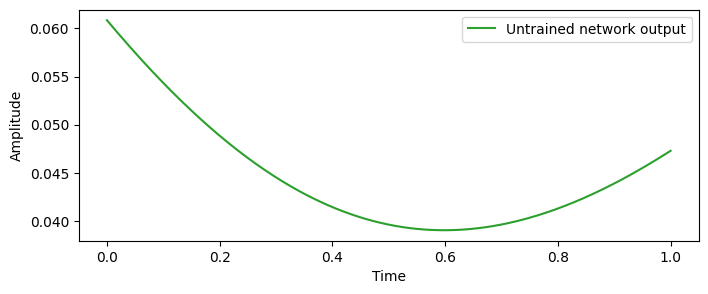

In [22]:
# set random seed
key = jax.random.PRNGKey(0)

# define the neural network architecture and initialise its parameters
network = FCN
parameters = network.init_parameters(key, [1,32,32,1])


## Task: plot the output of the untrained network
## hint: you can `vmap` network.forward to compute its output over a batch of input points

t_test_batch = jnp.linspace(0,1,300).reshape(-1,1)
u_test_batch = jax.vmap(network.forward, in_axes=(None, 0))(parameters, t_test_batch)
plt.figure(figsize=(8,3))
plt.plot(t_test_batch[:,0], u_test_batch[:,0], label="Untrained network output", color="tab:green")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

##

### Step 2: Computing the PINN loss function

Next, we will use `jax.grad` to compute first and second order gradients of the FCN's output with respect to its input, and use these gradients to evaluate the PINN's loss function.

Recall that the PINN loss function for the 1D harmonic oscillator problem is:

$$
L(\theta)= (\hat{u}(0,\theta) - 1)^2 + \lambda_1 \left(\frac{d \hat{u}}{dt}(0,\theta) - 0\right)^2 + \frac{\lambda_2}{N_I} \sum^{N_I}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] \hat{u}(t_{i},\theta)  \right)^2~.
$$

> Task 3: complete the `PINN_physics_loss`, `PINN_boundary_losses`, and `PINN_loss_batch` functions.

In [23]:
def PINN_physics_loss(parameters, t, network, mu, k):
    """Compute the physics loss for the 1D harmonic oscillator problem.
    Parameters:
        parameters: network parameters
        t: SINGLE input point of shape (1,)
        network: network class
        mu: coefficient of friction
        k: spring constant
    Returns:
        loss_physics: SINGLE SCALAR loss value of shape ()

    ODE:
    d^2 u      du
    ----- + mu -- + ku = 0
    dt^2       dt

    Boundary conditions:
    u (0) = 1
    u'(0) = 0
    """

    assert t.shape == (1,)

    def u_fn(t):
        """Calls network.forward, isolating u as a scalar function of a scalar input
        suitable for jax.grad"""
        return network.forward(parameters, t.reshape(1,)).squeeze()# has shape ()
    t = t.squeeze()# has shape ()

    u = u_fn(t)# has shape ()

    ## Task: use `jax.grad` to compute the gradients of u_fn at t, dudt and d2udt2, and then use
    ## these to compute the physics loss

    dudt_fn = jax.grad(u_fn)
    dudt = dudt_fn(t)

    d2udt2_fn = jax.grad(dudt_fn)
    d2udt2 = d2udt2_fn(t)

    loss_physics = (d2udt2 + mu*dudt + k*u)**2

    ##

    assert loss_physics.shape == ()
    return loss_physics


def PINN_boundary_losses(parameters, t, network):
    """Compute the two boundary losses for the 1D harmonic oscillator problem.
    Parameters:
        parameters: network parameters
        t: SINGLE input point of shape (1,)
        network: network class
    Returns:
        loss_displacement: SINGLE SCALAR loss value of shape ()
        loss_velocity: SINGLE SCALAR loss value of shape ()

    ODE:
    d^2 u      du
    ----- + mu -- + ku = 0
    dt^2       dt

    Boundary conditions:
    u (0) = 1
    u'(0) = 0
    """

    assert t.shape == (1,)

    def u_fn(t):
        """Calls network.forward, isolating u as a scalar function of a scalar input
        suitable for jax.grad"""
        return network.forward(parameters, t.reshape(1,)).squeeze()# has shape ()
    t = t.squeeze()# has shape ()

    ## Task: similar to `physics_loss`, compute u and dudt, and evaluate the boundary losses

    u = u_fn(t)
    dudt_fn = jax.grad(u_fn)
    dudt = dudt_fn(t)
    loss_displacement, loss_velocity = (u-1)**2, (dudt-0)**2

    ##

    assert loss_displacement.shape == loss_velocity.shape == ()
    return loss_displacement, loss_velocity


def PINN_loss_batch(parameters, t_boundary, t_physics_batch, network, mu, k):
    """Computes the total PINN loss for the harmonic oscillator problem, across a batch of collocation points.
    Parameters:
        parameters: network parameters
        t_boundary: SINGLE input point of shape (1,)
        t_physics_batch: BATCH of collocation points of shape (N, 1)
        network: network class
        mu: coefficient of friction
        k: spring constant
    Returns:
        loss: SINGLE SCALAR loss value of shape ()
    """

    assert t_boundary.shape == (1,) and t_physics_batch.ndim == 2

    ## Task: use `jax.vmap` to evaluate the physics loss over the batch of collocation points
    ## t_physics_batch, and compute the mean loss value across the batch.
    ## also evaluate the boundary losses for the single t_boundary point.

    loss_physics = jnp.mean(jax.vmap(PINN_physics_loss, in_axes=(None, 0, None, None, None))(
        parameters, t_physics_batch, network, mu, k))

    loss_displacement, loss_velocity = PINN_boundary_losses(parameters, t_boundary, network)

    ##

    assert loss_physics.shape == loss_displacement.shape == loss_velocity.shape == ()

    # sum all the losses together, weighting terms appropriately
    loss = 1e-4*loss_physics + loss_displacement + 1e-1*loss_velocity

    return loss

### Step 3: Training the PINN and evaluating performance

Finally, we need to train the PINN by optimising the PINN's loss function. Rather than write our own optimiser, in this example we will use the `adam` optimiser from the `optax` library.

> Task 4: train the PINN using the training code provided.

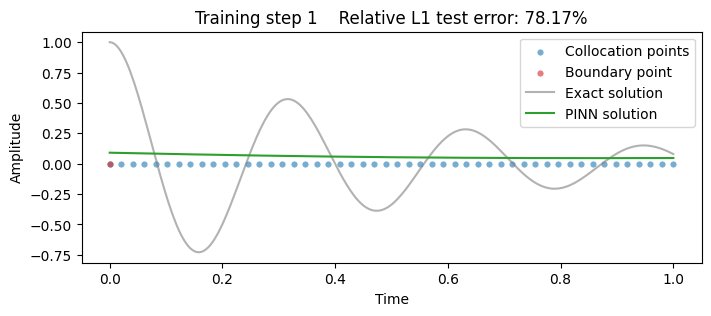

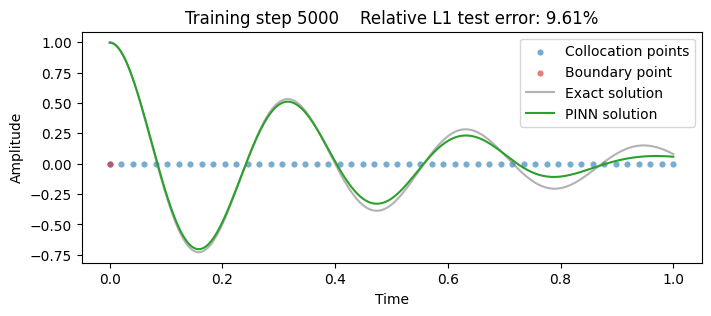

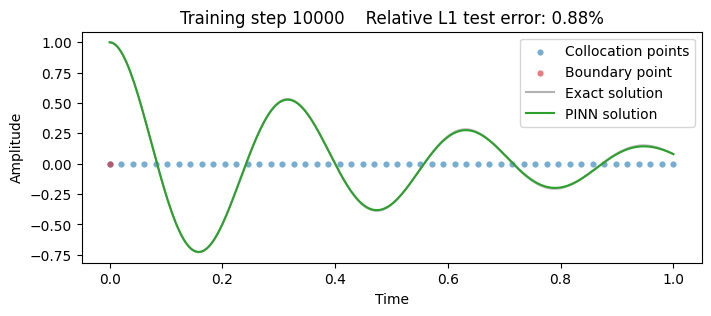

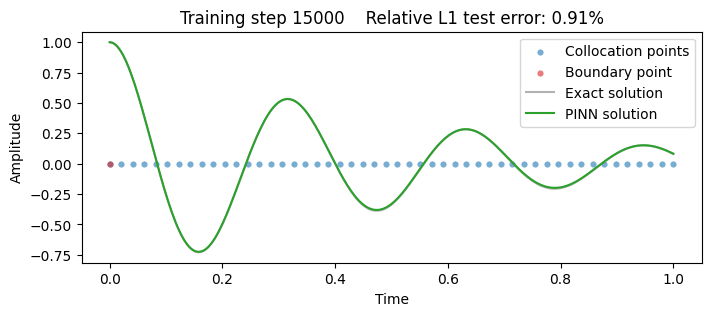

Total training time: 10.867940425872803 seconds


In [24]:
@partial(jax.jit, static_argnums=(1,5))# JAX best practice is to only `jit` your highest-level function
def PINN_step(opt_state, optimiser, parameters, t_boundary, t_physics_batch, network, mu, k):
    "Updates PINN parameters using the `optax` Adam optimiser"

    # get loss and gradient over batch
    loss, grads = jax.value_and_grad(PINN_loss_batch, argnums=0)(
        parameters, t_boundary, t_physics_batch, network, mu, k)

    # apply parameter update
    updates, opt_state = optimiser.update(grads, opt_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

    return loss, opt_state, parameters


# Train the PINN

# define boundary point, for the boundary loss
t_boundary = jnp.array([0.])# has shape (1,)

# define batch of training points over the entire problem domain [0,1], for the physics loss
t_physics_batch = jnp.linspace(0,1,50).reshape(-1,1)# has shape (50, 1)

# define ODE parameters
d, w0 = 2, 20
mu, k = 2*d, w0**2

# get dense test points and exact solution to compare to
t_test_batch = jnp.linspace(0,1,300).reshape(-1,1)
u_exact_batch = jax.vmap(exact_solution, in_axes=(None,None,0))(d, w0, t_test_batch)

# define the optimiser
optimiser = optax.adam(learning_rate=1e-3)
opt_state = optimiser.init(parameters)

# start training
start = time.time()
for i in range(15000):

    # update parameters
    loss, opt_state, parameters = PINN_step(
        opt_state, optimiser, parameters, t_boundary, t_physics_batch, network, mu, k)

    # plot the result as training progresses
    if (i+1)%5000 == 0 or i==0:

        # get PINN prediction and plot
        u_test_batch = jax.vmap(network.forward, in_axes=(None,0))(parameters, t_test_batch)
        plot_result(i, t_physics_batch, t_boundary, t_test_batch, u_exact_batch, u_test_batch)

print(f"Total training time: {time.time()-start} seconds")

> Task 5: measure the total training time, and compare this to the PyTorch implementation. Which is faster, PyTorch or JAX? Why?

> Task 6: measure the total training time without `jit` compilation - what's the difference?

> Task 7: increase the solution frequency, e.g. by setting `w0 = 40`, can you still train the PINN?

> Optional extension tasks. If you have the time, consider these extensions:
> 1. Can you optimise training speed and convergence rate any further (e.g. by changing the loss weighting, or network architecture?)
> 2. Solve an inverse problem with the PINN: add a supervised observational data loss to `PINN_loss_batch` and try to learn one of the ODE coefficients (e.g. mu) by including mu inside `parameters`

In [25]:
## Task: measure the total training time, and compare this to the PyTorch implementation.
## Which is faster, PyTorch or JAX? Why?

## Task: measure the total training time without `jit` compilation - what's the difference?

## Task: increase the solution frequency, e.g. by setting `w0 = 40`, can you still train the PINN?

## Task (optional extensions): if you have the time, consider these extensions:
    # 1. Can you optimise training speed and convergence rate any further (e.g. by changing the loss weighting, or network architecture?)
    # 2. Solve an inverse problem with the PINN: add a supervised observational data loss to `PINN_loss_batch`
    # and try to learn one of the ODE coefficients (e.g. mu) by including mu inside `parameters`